In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import numpy as np

## CycleGAN 

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, res_blocks=9):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.transform = nn.Sequential(*[ResidualBlock(256) for _ in range(res_blocks)])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.transform(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        x = self.main(x)
        return x


## Importing and Preprocessing Data

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

normal_dataset = ImageFolder('/kaggle/input/datagan6/Data/Base', transform=transform)
art_dataset = ImageFolder('/kaggle/input/datagan6/Data/Style', transform=transform)

normal_loader = DataLoader(normal_dataset, batch_size=1, shuffle=True)
art_loader = DataLoader(art_dataset, batch_size=1, shuffle=True)


## Displaying Style and Base datasets.

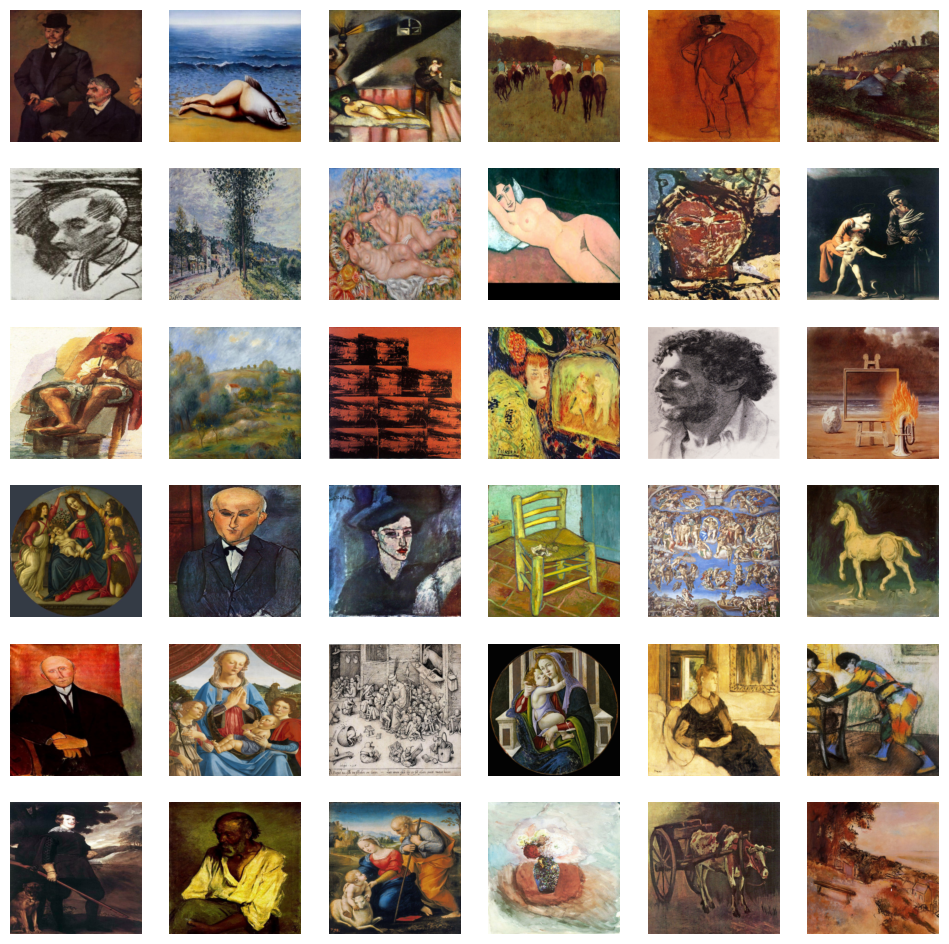

In [6]:
import matplotlib.pyplot as plt
import random
from PIL import Image

fig = plt.figure(figsize=(12,12))
for i in range(1, 37):
    fig.add_subplot(6,6,i)
    random_image_index = random.randint(0, len(art_dataset)-1)
    image, _ = art_dataset[random_image_index]
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

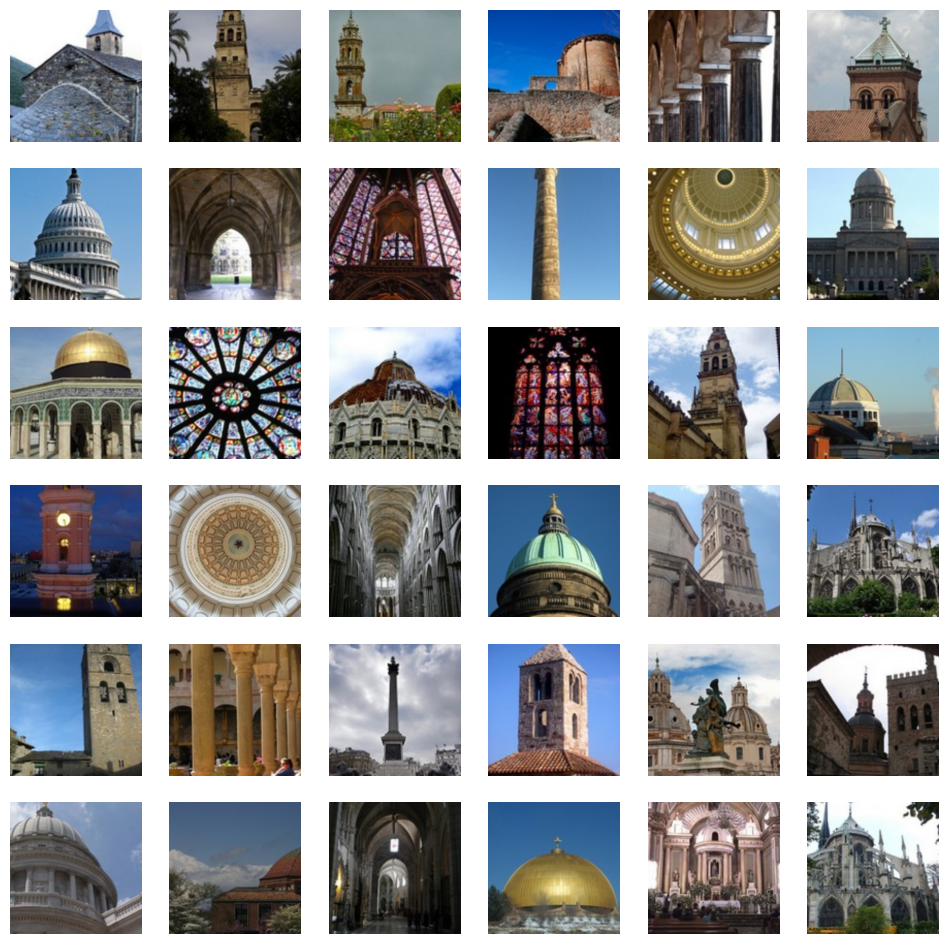

In [18]:
fig = plt.figure(figsize=(12,12))
for i in range(1, 37):
    fig.add_subplot(6,6,i)
    random_image_index = random.randint(0, len(normal_dataset)-1)
    image, _ = normal_dataset[random_image_index]
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

In [5]:
print(f"Number of normal images: {len(normal_loader.dataset)}")
print(f"Number of art images: {len(art_loader.dataset)}")

Number of normal images: 3500

Number of art images: 5600


In [6]:
# Checking normal images
normal_sizes = [img.size() for img, _ in normal_loader.dataset]
normal_unique_sizes = set(normal_sizes)
print("Unique image sizes in normal dataset:", normal_unique_sizes)

normal_channels = [img.size(0) for img, _ in normal_loader.dataset]
normal_unique_channels = set(normal_channels)
print("Unique color channels in normal dataset:", normal_unique_channels)

# Checking art images
art_sizes = [img.size() for img, _ in art_loader.dataset]
art_unique_sizes = set(art_sizes)
print("Unique image sizes in art dataset:", art_unique_sizes)

art_channels = [img.size(0) for img, _ in art_loader.dataset]
art_unique_channels = set(art_channels)
print("Unique color channels in art dataset:", art_unique_channels)

Unique image sizes in normal dataset: {torch.Size([3, 256, 256])}

Unique color channels in normal dataset: {3}

Unique image sizes in art dataset: {torch.Size([3, 256, 256])}

Unique color channels in art dataset: {3}


# Distribution of Color Intensity in Normal Images and Paintings

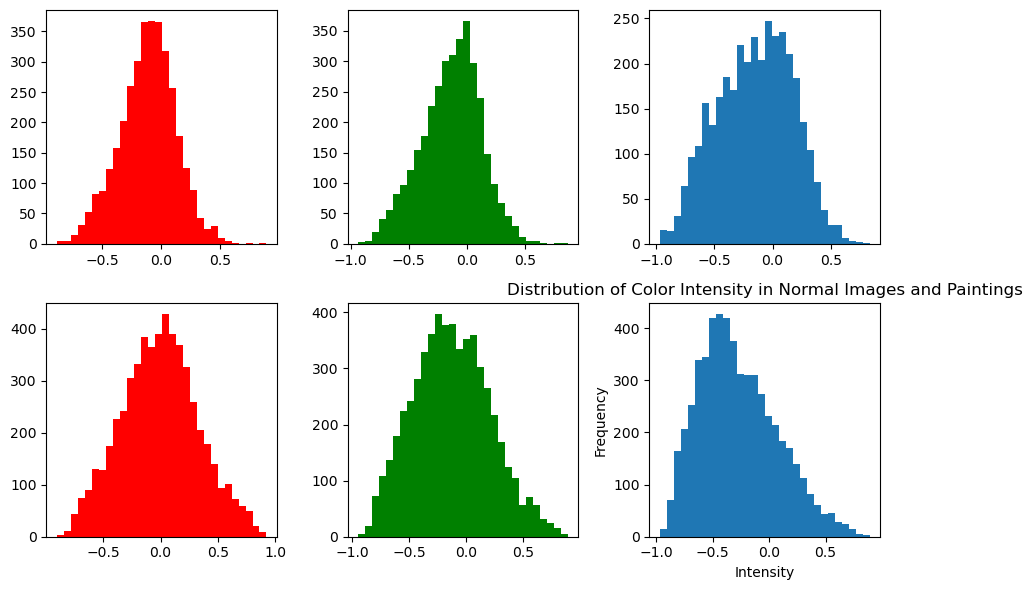

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

# Get all pixel intensities for a specific color channel (0 = Red, 1 = Green, 2 = Blue)
normal_intensities_r = [img[0].mean().item() for img, _ in normal_loader.dataset]
normal_intensities_g = [img[1].mean().item() for img, _ in normal_loader.dataset]
normal_intensities_b = [img[2].mean().item() for img, _ in normal_loader.dataset]
art_intensities_r = [img[0].mean().item() for img, _ in art_loader.dataset]
art_intensities_g = [img[1].mean().item() for img, _ in art_loader.dataset]
art_intensities_b = [img[2].mean().item() for img, _ in art_loader.dataset]

plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Color Intensity in Normal Images and Paintings")

# Plot histogram
axes[0,0].hist(normal_intensities_r, bins=30, color = 'red')
axes[0,1].hist(normal_intensities_g, bins=30, color = 'green')
axes[0,2].hist(normal_intensities_b, bins=30)
axes[1,0].hist(art_intensities_r, bins=30, color = 'red')
axes[1,1].hist(art_intensities_g, bins=30, color = 'green')
axes[1,2].hist(art_intensities_b, bins=30)

plt.tight_layout()
plt.show()


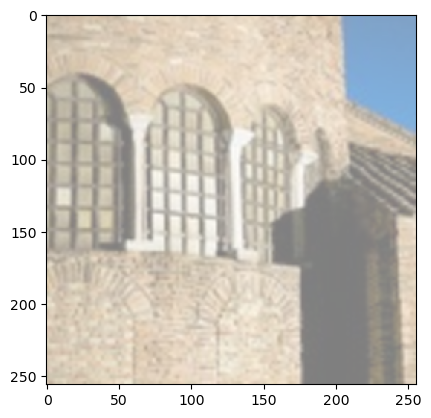

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(normal_loader)
images, _ = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Training CycleGAN

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G_normal = Generator().to(device)
G_art = Generator().to(device)
D_normal = Discriminator().to(device)
D_art = Discriminator().to(device)

# Optimizeer
G_optimizer = torch.optim.Adam(list(G_normal.parameters()) + list(G_art.parameters()), lr=0.001)
D_optimizer = torch.optim.Adam(list(D_normal.parameters()) + list(D_art.parameters()), lr=0.001)

# Loss Function
criterion = torch.nn.MSELoss()

In [8]:
num_epochs = 8

# Create infinite generator for both loaders
normal_loader_cycle = itertools.cycle(normal_loader)
art_loader_cycle = itertools.cycle(art_loader)

# Use only minimum number of batches from both loaders
num_batches = min(len(normal_loader), len(art_loader))

G_Loss = []
D_Loss = []
Epochs = []

for epoch in range(num_epochs):
    G_losses = []
    D_losses = []
    for batch in range(num_batches):
        normal_data, _ = next(normal_loader_cycle)
        art_data, _ = next(art_loader_cycle)

        normal_data = normal_data.to(device)
        art_data = art_data.to(device)

        # Forward pass through the generators
        fake_art = G_normal(normal_data)
        fake_normal = G_art(art_data)

        # Forward pass through the cycle
        cycle_normal = G_art(fake_art)
        cycle_art = G_normal(fake_normal)

        # Forward pass through the discriminators
        D_normal_real = D_normal(normal_data)
        D_normal_fake = D_normal(fake_normal)
        D_art_real = D_art(art_data)
        D_art_fake = D_art(fake_art)

        # Compute cycle consistency loss
        cycle_loss = criterion(cycle_normal, normal_data) + criterion(cycle_art, art_data)

        # Compute generator loss
        G_loss = criterion(D_normal_fake, torch.ones_like(D_normal_fake)) + criterion(D_art_fake, torch.ones_like(D_art_fake))

        # Add the cycle loss to the generator loss
        G_loss += 10.0 * cycle_loss  

        # Compute discriminator loss
        D_normal_loss = criterion(D_normal_real, torch.ones_like(D_normal_real)) + criterion(D_normal_fake, torch.zeros_like(D_normal_fake))
        D_art_loss = criterion(D_art_real, torch.ones_like(D_art_real)) + criterion(D_art_fake, torch.zeros_like(D_art_fake))
        D_loss = D_normal_loss + D_art_loss

        # Combine the losses for both the generator and the discriminator
        total_loss = G_loss + D_loss

        # Update generators
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()
        total_loss.backward()
        G_optimizer.step()
        D_optimizer.step()

        # Store the losses for later averaging
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    # Calculate the average loss over all batches
    avg_G_loss = sum(G_losses) / len(G_losses) 
    avg_D_loss = sum(D_losses) / len(D_losses)
    
    Epochs.append(epoch)
    G_Loss.append(avg_G_loss)
    D_Loss.append(avg_D_loss)

    print(f"Epoch: {epoch+1}/{num_epochs}, Generator Loss: {avg_G_loss:.4f}, Discriminator Loss: {avg_D_loss:.4f}")

Epoch: 1/8, Generator Loss: 3.1660, Discriminator Loss: 0.7810
Epoch: 2/8, Generator Loss: 1.9534, Discriminator Loss: 0.6138
Epoch: 3/8, Generator Loss: 1.7166, Discriminator Loss: 0.5850
Epoch: 4/8, Generator Loss: 1.5379, Discriminator Loss: 0.5459
Epoch: 5/8, Generator Loss: 1.4286, Discriminator Loss: 0.5501
Epoch: 6/8, Generator Loss: 1.3523, Discriminator Loss: 0.5290
Epoch: 7/8, Generator Loss: 1.3494, Discriminator Loss: 0.5464
Epoch: 8/8, Generator Loss: 1.2271, Discriminator Loss: 0.5226


# Loss-Epoch Curve

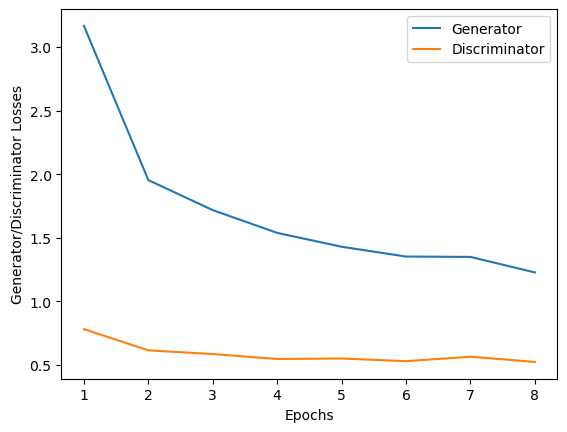

In [13]:
plt.plot(Epochs, G_Loss)
plt.plot(Epochs, D_Loss)
plt.xlabel('Epochs')
plt.ylabel('Generator/Discriminator Losses')
plt.legend(['Generator', 'Discriminator'], loc='upper right')
plt.show()

## Saving the model

In [14]:
# Save the models
torch.save(G_normal.state_dict(), 'G_normal.pth')
torch.save(G_art.state_dict(), 'G_art.pth')
torch.save(D_normal.state_dict(), 'D_normal.pth')
torch.save(D_art.state_dict(), 'D_art.pth')


## Viewing the results

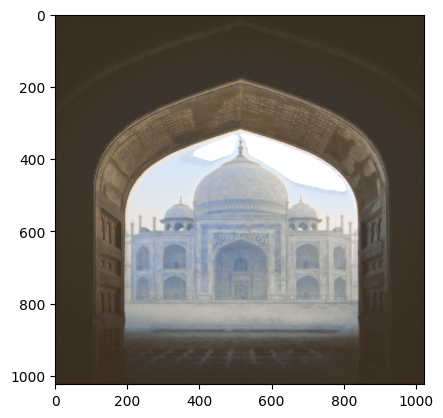

In [10]:
# Load the model
G_normal = Generator()
G_normal.load_state_dict(torch.load('G_art-2.pth', map_location=torch.device('cpu')))
G_normal.eval()

# Load the image
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

img = Image.open('pexels-victor-lavaud-3361480.jpg')
img = transform(img).unsqueeze(0)

# Convert the image
with torch.no_grad():
    art_img = G_normal(img)

# Save the output
output = transforms.ToPILImage()(art_img.squeeze())
plt.imshow(output)
output.save('art_picture.jpg')


# Verifying the results

In [12]:
# Load the model
D_art = Discriminator()
D_art.load_state_dict(torch.load('D_art-2.pth', map_location=torch.device('cpu')))
D_art.eval()
D_normal = Discriminator()
D_normal.load_state_dict(torch.load('D_normal-2.pth', map_location=torch.device('cpu')))
D_normal.eval()

# Checking whether the image is a real or fake artwork.
output = D_art(art_img)
probability_real = torch.mean(output).item()
print(probability_real)
# Compare the probability with a threshold
threshold = 0.5
if probability_real > threshold:
    print("The generated image is classified as real artwork.")
else:
    print("The generated image is classified as fake artwork.")

# Checking whether the image can be classified as a real or fake normal image.
output = D_normal(art_img)
probability_real = torch.mean(output).item()
print(probability_real)
# Compare the probability with a threshold
threshold = 0.5
if probability_real > threshold:
    print("The generated image is classified as real image.")
else:
    print("The generated image is classified as fake image.")

0.8689524531364441
The generated image is classified as real artwork.
0.3370647132396698
The generated image is classified as fake image.
